In [1]:
!python -V

Python 3.9.23


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import root_mean_squared_error

In [37]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/Users/namanpant/Documents/Temp/MLOps/mlops-zoomcamp/02-experiment-tracking/mlruns/2', creation_time=1750667940711, experiment_id='2', last_update_time=1750667940711, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [8]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [9]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

root_mean_squared_error(y_train, y_pred)

9.827368941909366

/var/folders/v4/1qlrk5lj6c10mv3899x58py00000gp/T/ipykernel_76594/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/v4/1qlrk5lj6c10mv3899x58py00000gp/T/ipykernel_76594/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

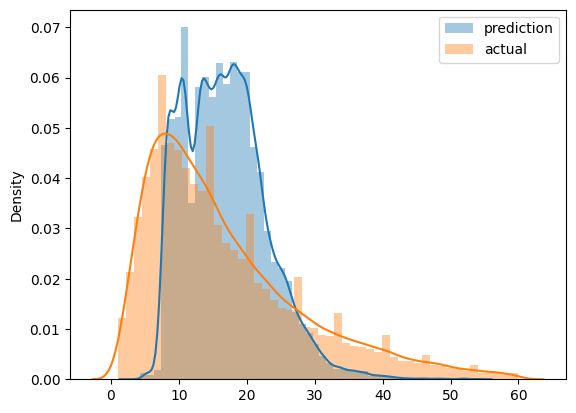

In [10]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [11]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [12]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [13]:
len(df_train), len(df_val)

(73908, 61921)

In [14]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [15]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [16]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [17]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

root_mean_squared_error(y_val, y_pred)

7.758715207732648

In [18]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [47]:
with mlflow.start_run():
    mlflow.set_tag("developer", "cristian")

    mlflow.log_param("train-data-path", "/data/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "/data/green_tripdata_2021-02.parquet")

    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    
    rmse = root_mean_squared_error(y_val, y_pred)
    mlflow.log_metric("rmse", rmse)

    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

In [20]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [27]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

print(type(train))

<class 'xgboost.core.DMatrix'>


In [40]:
def objective(params):
    
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, "validation")],
            early_stopping_rounds=50
        )

        y_val = booster.predict(valid)
        rmse = root_mean_squared_error(y_val, y_pred)

        mlflow.log_metric("rmse", rmse)

    return {"loss" : rmse, "status" : STATUS_OK}

In [42]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=10,
    trials=Trials()
)

[0]	validation-rmse:11.71965                          
  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:24:51] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:11.26594                          
[2]	validation-rmse:10.84935                          
[3]	validation-rmse:10.46751                          
[4]	validation-rmse:10.11812                          
[5]	validation-rmse:9.79872                           
[6]	validation-rmse:9.50738                           
[7]	validation-rmse:9.24196                           
[8]	validation-rmse:9.00039                           
[9]	validation-rmse:8.78088                           
[10]	validation-rmse:8.58172                          
[11]	validation-rmse:8.40115                          
[12]	validation-rmse:8.23775                          
[13]	validation-rmse:8.09034                          
[14]	validation-rmse:7.95705                          
[15]	validation-rmse:7.83608                          
[16]	validation-rmse:7.72730                          
[17]	validation-rmse:7.62860                          
[18]	validation-rmse:7.53975                          
[19]	valid

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:41] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.27221                                                    
[1]	validation-rmse:7.79200                                                    
[2]	validation-rmse:7.09484                                                    
[3]	validation-rmse:6.77049                                                    
[4]	validation-rmse:6.61630                                                    
[5]	validation-rmse:6.53842                                                    
[6]	validation-rmse:6.49065                                                    
[7]	validation-rmse:6.46535                                                    
[8]	validation-rmse:6.44467                                                    
[9]	validation-rmse:6.43403                                                    
[10]	validation-rmse:6.42699                                                   
[11]	validation-rmse:6.42247                                                   
[12]	validation-rmse:6.41872            

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:25:54] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[8]	validation-rmse:6.74979                                                    
[9]	validation-rmse:6.73496                                                    
[10]	validation-rmse:6.72541                                                   
[11]	validation-rmse:6.71957                                                   
[12]	validation-rmse:6.71554                                                   
[13]	validation-rmse:6.71283                                                   
[14]	validation-rmse:6.70843                                                   
[15]	validation-rmse:6.70372                                                   
[16]	validation-rmse:6.70138                                                   
[17]	validation-rmse:6.69863                                                   
[18]	validation-rmse:6.69563                                                   
[19]	validation-rmse:6.69350                                                   
[20]	validation-rmse:6.69031            

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:26:16] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.44191                                                   
[1]	validation-rmse:9.20557                                                    
[2]	validation-rmse:8.34206                                                    
[3]	validation-rmse:7.76169                                                    
[4]	validation-rmse:7.38406                                                    
[5]	validation-rmse:7.11991                                                    
[6]	validation-rmse:6.95381                                                    
[7]	validation-rmse:6.83067                                                    
[8]	validation-rmse:6.75274                                                    
[9]	validation-rmse:6.69280                                                    
[10]	validation-rmse:6.65348                                                   
[11]	validation-rmse:6.62229                                                   
[12]	validation-rmse:6.59643            

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:26:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:8.35323                                                    
[3]	validation-rmse:7.79994                                                    
[4]	validation-rmse:7.43746                                                    
[5]	validation-rmse:7.20114                                                    
[6]	validation-rmse:7.04748                                                    
[7]	validation-rmse:6.94770                                                    
[8]	validation-rmse:6.87732                                                    
[9]	validation-rmse:6.82865                                                    
[10]	validation-rmse:6.79571                                                   
[11]	validation-rmse:6.76779                                                   
[12]	validation-rmse:6.75002                                                   
[13]	validation-rmse:6.73576                                                   
[14]	validation-rmse:6.72544            

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:27:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.76600                                                    
[2]	validation-rmse:6.64579                                                    
[3]	validation-rmse:6.61207                                                    
[4]	validation-rmse:6.59265                                                    
[5]	validation-rmse:6.58339                                                    
[6]	validation-rmse:6.57730                                                    
[7]	validation-rmse:6.57153                                                    
[8]	validation-rmse:6.56722                                                    
[9]	validation-rmse:6.56100                                                    
[10]	validation-rmse:6.55661                                                   
[11]	validation-rmse:6.55450                                                   
[12]	validation-rmse:6.55189                                                   
[13]	validation-rmse:6.54862            

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:27:24] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:6.88169                                                    
[2]	validation-rmse:6.67654                                                    
[3]	validation-rmse:6.61723                                                    
[4]	validation-rmse:6.59428                                                    
[5]	validation-rmse:6.57557                                                    
[6]	validation-rmse:6.56970                                                    
[7]	validation-rmse:6.56485                                                    
[8]	validation-rmse:6.55732                                                    
[9]	validation-rmse:6.55066                                                    
[10]	validation-rmse:6.54555                                                   
[11]	validation-rmse:6.54240                                                   
[12]	validation-rmse:6.53494                                                   
[13]	validation-rmse:6.52785            

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:27:35] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[4]	validation-rmse:6.68369                                                    
[5]	validation-rmse:6.67226                                                    
[6]	validation-rmse:6.66656                                                    
[7]	validation-rmse:6.66254                                                    
[8]	validation-rmse:6.65769                                                    
[9]	validation-rmse:6.65337                                                    
[10]	validation-rmse:6.65072                                                   
[11]	validation-rmse:6.64664                                                   
[12]	validation-rmse:6.64315                                                   
[13]	validation-rmse:6.64047                                                   
[14]	validation-rmse:6.63836                                                   
[15]	validation-rmse:6.63587                                                   
[16]	validation-rmse:6.63429            

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:27:56] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.36607                                                    
[1]	validation-rmse:7.09062                                                    
[2]	validation-rmse:6.69099                                                    
[3]	validation-rmse:6.56230                                                    
[4]	validation-rmse:6.50279                                                    
[5]	validation-rmse:6.47322                                                    
[6]	validation-rmse:6.45804                                                    
[7]	validation-rmse:6.45009                                                    
[8]	validation-rmse:6.44473                                                    
[9]	validation-rmse:6.44044                                                    
[10]	validation-rmse:6.43348                                                   
[11]	validation-rmse:6.42741                                                   
[12]	validation-rmse:6.42325            

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [20:28:05] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[2]	validation-rmse:7.87249                                                    
[3]	validation-rmse:7.39104                                                    
[4]	validation-rmse:7.11001                                                    
[5]	validation-rmse:6.94495                                                    
[6]	validation-rmse:6.84329                                                    
[7]	validation-rmse:6.77739                                                    
[8]	validation-rmse:6.73523                                                    
[9]	validation-rmse:6.70514                                                    
[10]	validation-rmse:6.68455                                                   
[11]	validation-rmse:6.66962                                                   
[12]	validation-rmse:6.65788                                                   
[13]	validation-rmse:6.65000                                                   
[14]	validation-rmse:6.64288            

In [ ]:
import mlflow.xgboost
import mlflow.xgboost


best_params = {
    'max_depth': 17,
    'learning_rate': 0.204,
    'reg_alpha': 0.28,
    'reg_lambda': 0.00426,
    'min_child_weight': 1.240,
    'objective': 'reg:linear',
    'seed': 42
}
mlflow.log_params(best_params)
mlflow.xgboost.autolog(disable=True)

booster = xgb.train(
    params = best_params,
    dtrain = train,
    num_boost_round = 1000,
    evals = [(valid, "validation")],
    early_stopping_rounds = 50
    )
mlflow.log_metric("rmse", rmse)

with open("models/preprocessor.b", "wb") as f_out:
    pickle.dump(dv, f_out)

mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

mlflow.xgboost.log_model(
    booster,
    artifact_path="models_mlflow"
)

/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:18:39] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:10.62646
[1]	validation-rmse:9.46253
[2]	validation-rmse:8.62120
[3]	validation-rmse:8.02998
[4]	validation-rmse:7.61364
[5]	validation-rmse:7.32026
[6]	validation-rmse:7.12005
[7]	validation-rmse:6.97865
[8]	validation-rmse:6.87794
[9]	validation-rmse:6.80717
[10]	validation-rmse:6.75424
[11]	validation-rmse:6.71755
[12]	validation-rmse:6.69078
[13]	validation-rmse:6.66858
[14]	validation-rmse:6.65096
[15]	validation-rmse:6.63816
[16]	validation-rmse:6.62608
[17]	validation-rmse:6.61829
[18]	validation-rmse:6.61174
[19]	validation-rmse:6.60657
[20]	validation-rmse:6.60350
[21]	validation-rmse:6.60169
[22]	validation-rmse:6.60125
[23]	validation-rmse:6.60025
[24]	validation-rmse:6.59788
[25]	validation-rmse:6.59572
[26]	validation-rmse:6.59317
[27]	validation-rmse:6.59083
[28]	validation-rmse:6.58995
[29]	validation-rmse:6.58717
[30]	validation-rmse:6.58536
[31]	validation-rmse:6.58297
[32]	validation-rmse:6.58135
[33]	validation-rmse:6.57987
[34]	validation-rmse:6.

2025/06/23 21:19:06 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/opt/homebrew/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:19:06] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)
2025/06/23 21:19:08 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
